<a href="https://colab.research.google.com/github/MateoPatinoRios/ABC/blob/main/Tarea05_1007362148.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.0 Derivación

In [ ]:
import numpy as np

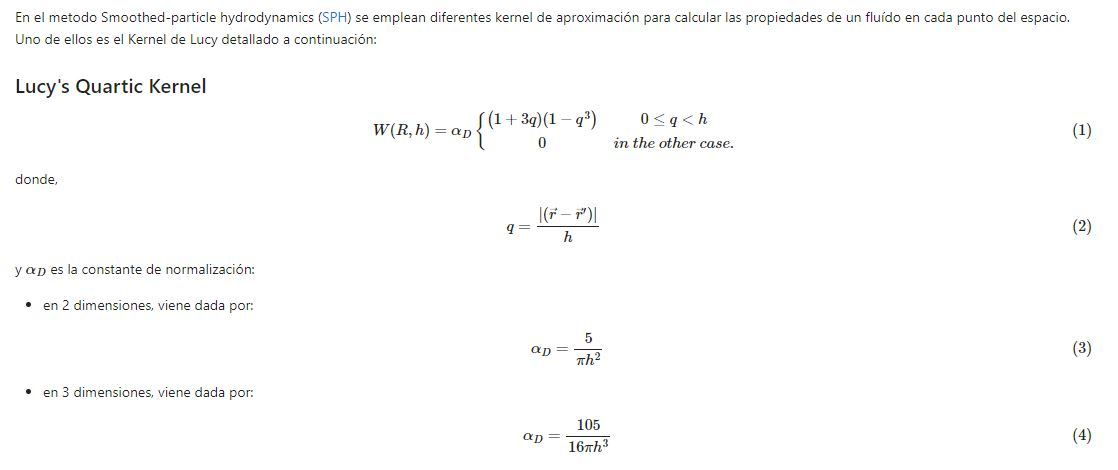

In [ ]:
from IPython.display import Image
Image("primerpuntoderivada.JPG")

El método smoothed-particle hydrodynamics (SPH) funciona dividiendo el fluido en un conjunto de elementos discretos, a los cuales se refiere como partículas. Estas partículas tienen una distancia espacial (conocida como "longitud de suavizado", típicamente representada en ecuaciones como **$h$**, sobre las cuales sus propiedades se "suavizan" mediante una función núcleo. Esto significa que la cantidad física de cualquier partícula se puede obtener sumando las propiedades relevantes de todas las partículas que se encuentran dentro del rango del núcleo.

Definamos $|(\vec{r}-\vec{r'})|=R$ entonces $q=\frac{R}{h}$

Para nuestro caso se solucionará el caso 2D por ello:

In [ ]:
def W(R,h):
    αD=5/(np.pi*h**2)
    if R/h<h:
        return αD*(1+3*R/h)*(1-(R/h))**3
    else:
        return 0

**1.Realizar un gráfico del kernel de Lucy.**

Se escogerá un h=1.0

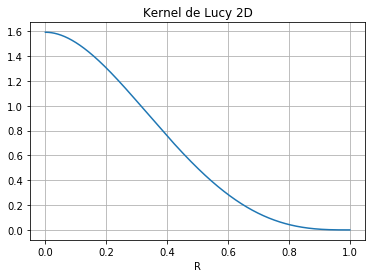

In [ ]:
from sympy import diff,lambdify,symbols,expand
import sympy as sp
import matplotlib.pylab as plt
R=np.linspace(0,1,1000)
wl=[]
for i in range(0,R.size):
    wl.append(W(R[i],h=1))
wl=np.array(wl)
plt.plot(R,wl)
plt.title('Kernel de Lucy 2D')
plt.xlabel('R')
plt.grid()

**2. Encontrar la derivada empleanda la libreria simbolica**

In [ ]:
def Wp(R,h=1):
    αD=5/(np.pi*h**2)
    return αD*(1+3*R/h)*(1-(R/h)**3)
R=symbols('R')
#Derivada analítica del Kernel de Lucy
diff(Wp(R),'R')

-4.77464829275686*R**3 - 3*R**2*(4.77464829275686*R + 1.59154943091895) + 4.77464829275686

**3. Realizar un grafico de los cálculos encontrados con la libreria simbólica y comparar con la derivada numérica de los datos del punto 1.**

Para realizar la derivada numérica se utilizará la versión vectorizada de misc.derivative

In [ ]:
from scipy import misc
def derivate(func,x0,**kwargs):
    '''
    Vectorized replacement of scipy.misc derivative:
        from scipy.misc import derivative
    For usage check the derivative help, e.g, in jupyter: 
        from scipy.misc import derivative
        derivative?
    '''
    try:
        #x0: can be an array or a list  
        nn=np.asarray(x0).shape[0] # force error if float is used 
        fp=np.vectorize(misc.derivative)
    except IndexError:
        fp=misc.derivative
        
    return fp(func,x0,**kwargs)

In [ ]:
misc.derivative?

Signature: misc.derivative(func, x0, dx=1.0, n=1, args=(), order=3)
Docstring:
Find the n-th derivative of a function at a point.

Given a function, use a central difference formula with spacing `dx` to
compute the `n`-th derivative at `x0`.

Parameters
----------
func : function
    Input function.
x0 : float
    The point at which `n`-th derivative is found.
dx : float, optional
    Spacing.
n : int, optional
    Order of the derivative. Default is 1.
args : tuple, optional
    Arguments
order : int, optional
    Number of points to use, must be odd.

Notes
-----
Decreasing the step size too small can result in round-off error.

Examples
--------
>>> from scipy.misc import derivative
>>> def f(x):
...     return x**3 + x**2
>>> derivative(f, 1.0, dx=1e-6)
4.9999999999217337
File:      c:\users\usuario\anaconda3\lib\site-packages\scipy\misc\common.py
Type:      function


Se puede observar que el método **misc.derivative** calcula la n-ésima derivada de una función en un punto mediante una diferencia finita centrada para la primera derivada:
$$f'(x)=\frac{f(x+\frac{h}{2})-f(x-\frac{h}{2})}{h}-\frac{h^2}{24}f'''(x)+...$$
Se puede observar entonces que el error en el cálculo numérico debido al truncamiento del polinomio de Taylor de f(x) alrededor de x depende de h, pero se debe tener un especial cuidado al escoger el respectivo h (**En misc.derivative es dx**) ya que la diferencia numérica es un método inestable, ya que si h disminuye mucho es posible que el error por redondeo aumente significativamente, por ello se debe escoger h con cuidado. *Recordar que es un h diferente al del Kernel de Lucy*

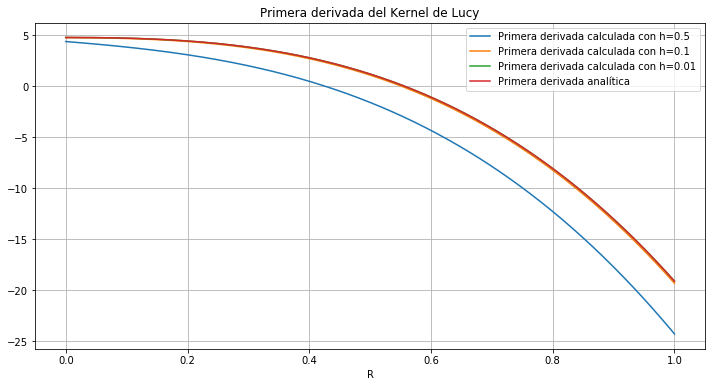

In [ ]:
rr=np.linspace(0,1,1000)
plt.figure(figsize=(12,6))
plt.plot(rr,derivate(Wp,rr,dx=0.5))
plt.plot(rr,derivate(Wp,rr,dx=0.1))
plt.plot(rr,derivate(Wp,rr,dx=0.01))
plt.plot(rr,lambdify('R',diff(Wp(R),'R'),'numpy')(rr))
plt.title('Primera derivada del Kernel de Lucy')
plt.xlabel('R')
plt.grid()
plt.legend(['Primera derivada calculada con h=0.5','Primera derivada calculada con h=0.1','Primera derivada calculada con h=0.01','Primera derivada analítica'])

# 2.0 Integración

Escribir en código Markdown la expresión para calcular una integral con la regla del trapecio.

**Integración compuesta:** El método de Newton-Cotes falla para intervalos muy grandes (Muchos puntos de interpolación) debido a la naturaleza de los polinomios de interpolación de Lagrange (Fenómeno de Runge), los cuales oscilan para un alto grado del polinomio. Una mejor idea es dividir el intervalo en n subintervalos y aplicar un método de Newton-Cotes de menor grado en cada subintervalo.

Se divide el intervalo [a,b] en n+1 puntos y aplicar en cada intervalo de 2 puntos la regla del trapecio con $h=\frac{b-a}{n}$ y $x_{j}=a+jh$ tal que existe $\mu$ para el que: $$\int_{a}^{b}f(x)dx=\frac{h}{2}[f(a)+2\sum_{j=1}^{n-1}f(x_{j})+f(b)]-\frac{(b-a)}{12}h^2f"(\mu)$$

Se podría hacer una abstracción del álgebra lineal para realizar este producto:
    
$$\int_{a}^{b}f(x)dx=\frac{h}{2}[f(a)+2\sum_{j=1}^{n-1}f(x_{j})+f(b)]-\frac{(b-a)}{12}h^2f"(\mu)=\frac{1}{2}[h(f(x_{0})+f(x_{1}))+...+h(f(x_{n-1})+f(x_{n}))]+-\frac{(b-a)}{12}h^2f"(\mu)$$

sea $x_{j}-x_{j-1}=a+jh-a-(j-1)h=h$ (h es el mismo para cada subintervalo por estar equiespaciados) entonces reemplazando:

$$\int_{a}^{b}f(x)dx=\frac{1}{2}[(x_{1}-x_{0})(f(x_{0})+f(x_{1}))+(x_{2}-x_{1})(f(x_{1})+f(x_{2}))+...+(x_{n}-x_{n-1})(f(x_{n-1})+f(x_{n}))]-\frac{(b-a)}{12}h^2f"(\mu)$$

Por otro lado si se tiene $\begin{equation}
\begin{pmatrix}
(x_{1}-x_{0}) & (x_{2}-x_{1}) & ... & (x_{n}-x_{n-1}) \\
\end{pmatrix}
\begin{pmatrix}
(f(x_{1})+f(x_{0})) \\ (f(x_{2})+f(x_{1})) \\ ... \\ (f(x_{n})+f(x_{n-1})) \\
\end{pmatrix}
\end{equation}$ para el cual efectuando el producto de matrices es igual a $(x_{1}-x_{0})(f(x_{0})+f(x_{1}))+...+(x_{n}-x_{n-1})(f(x_{n-1})+f(x_{n}))$ entonces podríamos reemplazar esta igualdad en la regla del trapecio compuesta y obtener lo siguiente:

Sea $X=\begin{pmatrix}
(x_{1}-x_{0}) & (x_{2}-x_{1}) & ... & (x_{n}-x_{n-1}) \\
\end{pmatrix}$ y $F=\begin{pmatrix}
(f(x_{1})+f(x_{0})) \\ (f(x_{2})+f(x_{1})) \\ ... \\ (f(x_{n})+f(x_{n-1})) \\
\end{pmatrix}$

Para los cuales se tiene que:
$$\int_{a}^{b}f(x)dx=\frac{1}{2}X\cdot F-\frac{(b-a)}{12}h^2f"(\mu)$$


Escribir en código Markdown la expresión para calcular una integral con la regla del simpson

Otra idea sería utilizar la regla de Simpson en cada subintervalo para lo cual se tendría que: Se divide el intervalo [a,b] en n+1 puntos y aplicar en cada intervalo de 3 puntos la regla de Simpson con (n par) $h=\frac{b-a}{n}$ y $x_{j}=a+jh$ tal que existe $\mu$ para el que: $$\int_{a}^{b}f(x)dx=\frac{h}{3}[f(a)+2\sum_{j=1}^{(\frac{n}{2})-1}f(x_{2j})+4\sum_{j=1}^{\frac{n}{2}}f(x_{2j-1})+f(b)]-\frac{(b-a)}{180}h^4f^{(4)}(\mu)$$

Las siguientes integrales se calcularán utilizando los métodos del Trapecio, la regla de Simpson y el método de cuadratura 

$$\int_{0}^{\pi}e^{1-\sqrt{x}}dx$$

In [ ]:
from scipy import integrate

**La integración numérica es estable, esto quiere decir que se puede escoger un valor de h tan pequeño como se quiera sin incurrir en errores de redondeo.** Por ello mientras más puntos se utilicen en la evaluación más exacto será el valor de la integral

In [ ]:
def f(x):
    return np.exp(1-x**(1/2))

Para el método del trapecio se utilizará la abstracción del álgebra lineal

In [ ]:
x=np.linspace(0,np.pi,10000)
Δx=x[1:]-x[:-1]
y=f(x)
F=y[1:]+y[:-1]
trap=1/2*Δx@F
print(f'Mediante la abstracción del álgebra lineal para calcular la integral mediante la regla del trapecio se obtiene un valor de la integral igual a: {trap}, por otro lado, mediante el método de scipy se obtiene: {integrate.trapz(y,x)}')

Mediante la abstracción del álgebra lineal para calcular la integral mediante la regla del trapecio se obtiene un valor de la integral igual a: 2.875494270302392, por otro lado, mediante el método de scipy se obtiene: 2.8754942703023914


In [ ]:
print(f'El cálculo de la integral mediante la regla de Simpson es: {integrate.simps(y,x)}')

El cálculo de la integral mediante la regla de Simpson es: 2.875493020942959


In [ ]:
print(f'El cálculo de la integral mediante el método de cuadratura es: {integrate.quad(f,0,np.pi,limit=100)[0]}')

El cálculo de la integral mediante el método de cuadratura es: 2.875491135437586


$$\int_{0}^{\frac{\pi}{2}}\frac{1}{\sqrt{\tan(x)}}dx$$

In [ ]:
def f(x):
    return 1/(np.tan(x))**(1/2)

In [ ]:
x=np.linspace(1e-5,np.pi/2,1000000)
Δx=x[1:]-x[:-1]
y=f(x)
F=y[1:]+y[:-1]
trap=1/2*Δx@F
print(f'Mediante la abstracción del álgebra lineal para calcular la integral mediante la regla del trapecio se obtiene un valor de la integral igual a: {trap}, por otro lado, mediante el método de scipy se obtiene: {integrate.trapz(y,x)}')

Mediante la abstracción del álgebra lineal para calcular la integral mediante la regla del trapecio se obtiene un valor de la integral igual a: 2.215120159433052, por otro lado, mediante el método de scipy se obtiene: 2.2151201594330536


Se presenta una asíntota en el extremo derecho del intervalo de integración, por ello la regla del trapecio es mala para calcular este tipo de integrales, se requiere dividir el intervalo en muchos puntos para obtener un resultado aproximado.

In [ ]:
print(f'El cálculo de la integral mediante la regla de Simpson es: {integrate.simps(y,x)}')

El cálculo de la integral mediante la regla de Simpson es: 2.215117247453263


In [ ]:
print(f'El cálculo de la integral mediante el método de cuadratura es: {integrate.quad(f,0,np.pi/2,limit=100)[0]}, el error en este cálculo es: {integrate.quad(f,0,np.pi/2,limit=100)[1]}')

El cálculo de la integral mediante el método de cuadratura es: 2.221441469079176, el error en este cálculo es: 4.1407366424550673e-10


$$\int_{-\infty}^{\infty}\frac{1}{1+x^2}dx$$

In [ ]:
def f(x):
    return 1/(1+x**2)

In [ ]:
x=np.linspace(-10000,10000,1000000)
Δx=x[1:]-x[:-1]
y=f(x)
F=y[1:]+y[:-1]
trap=1/2*Δx@F
print(f'Mediante la abstracción del álgebra lineal para calcular la integral mediante la regla del trapecio se obtiene un valor de la integral igual a: {trap}, por otro lado, mediante el método de scipy se obtiene: {integrate.trapz(y,x)}')

Mediante la abstracción del álgebra lineal para calcular la integral mediante la regla del trapecio se obtiene un valor de la integral igual a: 3.1413926535904575, por otro lado, mediante el método de scipy se obtiene: 3.1413926535904584


In [ ]:
print(f'El cálculo de la integral mediante la regla de Simpson es: {integrate.simps(y,x)}')

El cálculo de la integral mediante la regla de Simpson es: 3.1413926535904606


In [ ]:
print(f'El cálculo de la integral mediante el método de cuadratura es: {integrate.quad(f,-np.inf,np.inf,limit=100)[0]}, el error en este cálculo es: {integrate.quad(f,-np.inf,np.inf,limit=100)[1]}')

El cálculo de la integral mediante el método de cuadratura es: 3.141592653589793, el error en este cálculo es: 5.155583041197975e-10


$$\int_{0}^{\frac{\pi}{4}}\int_{\cos{x}}^{\sin{x}}(2y\sin{x}+\cos^2{x})dydx$$

La primera integral respecto a la variable y se puede resolver analíticamente, por tanto sólo se tiene que resolver numéricamente la integral para la variable x.

$$\int_{0}^{\frac{\pi}{4}}(\sin{x} (\cos^2{x}-\sin^2{x})+\cos^2{x} (\cos{x}-\sin{x}))dx$$

In [ ]:
def f(x):
    return np.sin(x)*((np.cos(x))**2-(np.sin(x))**2)+(np.cos(x))**2*(np.cos(x)-np.sin(x))

In [ ]:
x=np.linspace(0,np.pi/4,100000)
Δx=x[1:]-x[:-1]
y=f(x)
F=y[1:]+y[:-1]
trap=1/2*Δx@F
print(f'Mediante la abstracción del álgebra lineal para calcular la integral mediante la regla del trapecio se obtiene un valor de la integral igual a: {trap}, por otro lado, mediante el método de scipy se obtiene: {integrate.trapz(y,x)}')

Mediante la abstracción del álgebra lineal para calcular la integral mediante la regla del trapecio se obtiene un valor de la integral igual a: 0.5118446353000079, por otro lado, mediante el método de scipy se obtiene: 0.5118446353000078


In [ ]:
print(f'El cálculo de la integral mediante la regla de Simpson es: {integrate.simps(y,x)}')

El cálculo de la integral mediante la regla de Simpson es: 0.5118446353109125


In [ ]:
print(f'El cálculo de la integral mediante el método de cuadratura es: {integrate.quad(f,0,np.pi/4,limit=100)[0]}, el error en este cálculo es: {integrate.quad(f,0,np.pi/4,limit=100)[1]}')

El cálculo de la integral mediante el método de cuadratura es: 0.5118446353109126, el error en este cálculo es: 5.682616991530416e-15


$$\int_{e}^{2e}\frac{1}{\ln x}dx$$

In [ ]:
def f(x):
    return 1/np.log(x)

In [ ]:
x=np.linspace(np.exp(1),2*np.exp(1),100000)
Δx=x[1:]-x[:-1]
y=f(x)
F=y[1:]+y[:-1]
trap=1/2*Δx@F
print(f'Mediante la abstracción del álgebra lineal para calcular la integral mediante la regla del trapecio se obtiene un valor de la integral igual a: {trap}, por otro lado, mediante el método de scipy se obtiene: {integrate.trapz(y,x)}')

Mediante la abstracción del álgebra lineal para calcular la integral mediante la regla del trapecio se obtiene un valor de la integral igual a: 2.0038105616427258, por otro lado, mediante el método de scipy se obtiene: 2.003810561642726


In [ ]:
print(f'El cálculo de la integral mediante la regla de Simpson es: {integrate.simps(y,x)}')

El cálculo de la integral mediante la regla de Simpson es: 2.0038105616240243


In [ ]:
print(f'El cálculo de la integral mediante el método de cuadratura es: {integrate.quad(f,np.exp(1),2*np.exp(1),limit=100)[0]}, el error en este cálculo es: {integrate.quad(f,np.exp(1),2*np.exp(1),limit=100)[1]}')

El cálculo de la integral mediante el método de cuadratura es: 2.0038105616240243, el error en este cálculo es: 2.2246766225020577e-14


Suppose a body of mass m is traveling vertically upward starting at the surface of the earth. If all resistance except gravity is neglected, the escape velocity v is given by
where z=x/R
$$v=\sqrt{2gR\int_{1}^{\infty}z^{-2}dz}$$
R is the earth radius and g de gravity aceleration. Approximate the scape velocity

In [ ]:
R=6371*1000 #m Tomado de: https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html
g=9.8 #m/s^2

In [ ]:
def f(z):
    return 1/z**2
v=np.sqrt(2*g*R*integrate.quad(f,1,np.inf)[0]) 
print(f'La velocidad de escape del cuerpo es {v} m/s')

La velocidad de escape del cuerpo es 11174.596189572132 m/s


 Write a double precision program to integrate an arbitrary function numerically using the trapezoid rule, the Simpson rule, and Gaussian quadrature. For our assumed problems there is an analytics answer:

$$\frac{dN(t)}{dt}=e^{-t}$$

$$N(t)=\int_{0}^{1}e^{-t}dt=1-e^{-1}$$

Compute the relative error  in each case. Present your data in the tabular form with space or tabas seprating the field. Try N values of 2, 10, 20 , 40 , 80, 160

In [ ]:
def f(t):
    return np.exp(-t)

**Función que me da los errores relativos de cada método de integración para un respectivo valor de t**

In [ ]:
def ϵTrap(N):
    x=np.linspace(0,1,N)
    y=f(x)
    integral=integrate.trapz(y,x)
    exact=1-np.exp(-1)
    return np.abs(integral-exact)/np.abs(exact)

In [ ]:
def ϵSimp(N):
    x=np.linspace(0,1,N)
    y=f(x)
    integral=integrate.simps(y,x)
    exact=1-np.exp(-1)
    return np.abs(integral-exact)/np.abs(exact)

In [ ]:
def ϵGauss(N):
    integral=integrate.quad(f,0,1,points=N)[0]
    exact=1-np.exp(-1)
    return np.abs(integral-exact)/np.abs(exact)

In [ ]:
import pandas as pd
N=[2,10,20,40,80,160]
Trap=[]
Simp=[]
Gauss=[]
for t in N:
    Trap.append(ϵTrap(t))
    Simp.append(ϵSimp(t))
    Gauss.append(ϵGauss(t))
N=np.array(N)
Trap=np.array(Trap)
Simp=np.array(Simp)
Gauss=np.array(Gauss)
df=pd.DataFrame({'N':N,'ϵT':Trap,'ϵS':Simp,'ϵG':Gauss})
df

,N,ϵT,ϵS,ϵG
0,2,0.081977,8.197671e-02,1.756347e-16
1,10,0.001029,1.214802e-04,1.756347e-16
2,20,0.000231,1.303125e-05,1.756347e-16
3,40,0.000055,1.513477e-06,1.756347e-16
4,80,0.000013,1.824856e-07,1.756347e-16
5,160,0.000003,2.240700e-08,1.756347e-16


Make a log-log plot of relative errore versus. You should observe that: $\epsilon \cong CN^{\alpha}$, $\log{\epsilon}=\alpha \log{N}+\log{C}$ . This mean that a power-law dependence appears as a straight line on a log-log plot, and that if you use 
, the the ordinate on your log-log plot will be the negative of the numver of decimal places of presicion in your calculation. 6.4. Use your plot or table to stimate the power-law dependence of the error  on the number of points N and to determine the number of decimal places of presicion in your calculation. Do this for both the trapezoid and simpsons rules and for both the algolrithmic and round-off error regimes. (Note that if may be hard to reach the round-off error regime for the trapezoid rule becasue the aproximation ) error is so large

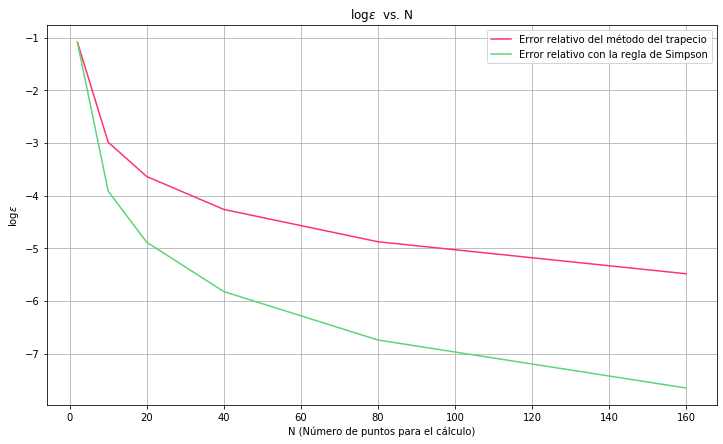

In [ ]:
plt.figure(figsize=(12,7))
ϵT=np.log10(Trap)
ϵS=np.log10(Simp)
plt.plot(N,ϵT,c="#FF3368")
plt.plot(N,ϵS,c="#5BD577")
plt.title('$\log{\epsilon}$  vs. N')
plt.xlabel('N (Número de puntos para el cálculo)')
plt.ylabel('$\log{\epsilon}$')
plt.legend(['Error relativo del método del trapecio','Error relativo con la regla de Simpson'])
plt.grid()

Se hallará las constantes de la dependencia de la ley de la potencia de $\epsilon$ respecto a N mediante el método de los mínimos cuadrados. Para este caso X será $\log{N}$ y Y será $\log{\epsilon}$.

In [ ]:
Yprom=ϵT.mean()
Xprom=(np.log10(N)).mean()
XY=[]
for i in range(0,N.size):
    XY.append(np.log10(df['ϵT'][i])*np.log10(df['N'][i]))
XY=np.array(XY)
XYprom=XY.mean()
X2=((np.log10(N))**2).mean()
αT=(XYprom-Xprom*Yprom)/(X2-Xprom**2)
CT=10**(Yprom-αT*Xprom)

In [ ]:
def logT(N):
    return αT*np.log10(N)+np.log10(CT)

In [ ]:
Yprom=ϵS.mean()
Xprom=(np.log10(N)).mean()
XY=[]
for i in range(0,N.size):
    XY.append(np.log10(df['ϵS'][i])*np.log10(df['N'][i]))
XY=np.array(XY)
XYprom=XY.mean()
X2=((np.log10(N))**2).mean()
αS=(XYprom-Xprom*Yprom)/(X2-Xprom**2)
CS=10**(Yprom-αS*Xprom)

In [ ]:
def logS(N):
    return αS*np.log10(N)+np.log10(CS)

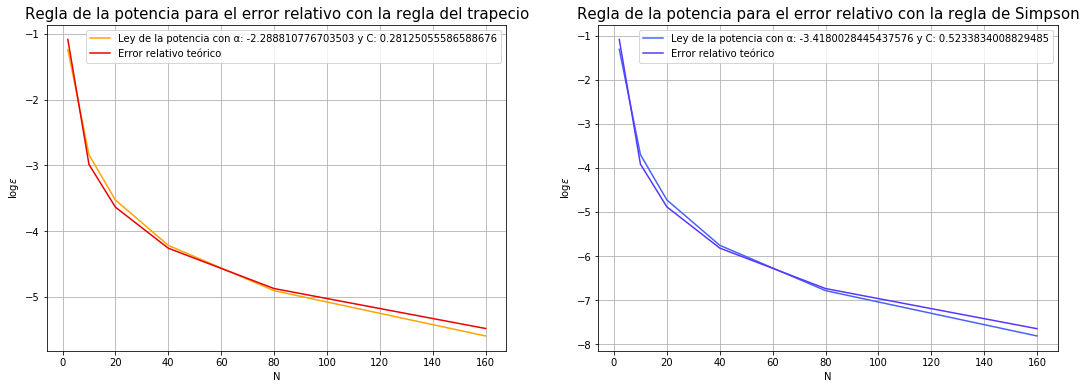

In [ ]:
plt.figure(figsize = (28,6))
plt.subplot(131)
plt.plot(N,logT(N),c='#FFA301')
plt.plot(N,np.log10(df['ϵT']),c='#E80000')
plt.title('Regla de la potencia para el error relativo con la regla del trapecio',fontsize=15)
plt.xlabel('N')
plt.ylabel('$\log{\epsilon}$')
plt.legend([f'Ley de la potencia con α: {αT} y C: {CT}','Error relativo teórico'])
plt.grid()
plt.subplot(132)
plt.plot(N,logS(N),c='#4662FF')
plt.plot(N,np.log10(df['ϵS']),c='#5836FF')
plt.title('Regla de la potencia para el error relativo con la regla de Simpson',fontsize=15)
plt.xlabel('N')
plt.ylabel('$\log{\epsilon}$')
plt.legend([f'Ley de la potencia con α: {αS} y C: {CS}','Error relativo teórico'])
plt.grid()